In [1]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import dateutil
import time
import tqdm
import obspy
import datetime
import os
import glob
import pytz

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = { 
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
def read_PASSCAL_SEGY_headers(infile):
    """Function to read information within SEGY PASSCAL headers"""
    nTxtFileHeader=3200
    nBinFileHeader=400
    nTraceHeader=240
    if infile.split(".")[-1] == "segy":
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        fid = gzip.open(infile, 'rb')
    fid.seek(0,2)
    filesize = fid.tell()
    startData = nTxtFileHeader+20
    fid.seek(startData)
    BinBuffer = fid.read(2)
    nt = int.from_bytes(BinBuffer, byteorder='big', signed=False)
    fid.seek(nTxtFileHeader+16)
    dt = int.from_bytes(fid.read(2), byteorder='big', signed=False)*1e-6
    if dt == 0.0:
        fs = 0.0
    else:
        fs = 1.0/dt
    # Getting UTC time first sample
    fid.seek(nTxtFileHeader+nBinFileHeader+156)
    year = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    day = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    hour = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    minute = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    second = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    print([year, day, hour, minute, second])
    TIME_BASIS_CODE = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    print(TIME_BASIS_CODE)
    micsec = int.from_bytes(fid.read(4), byteorder='big', signed=False)
    second = second+micsec*1e-6
    startTime = datetime.datetime.strptime("%s-%s"%(year,day),"%Y-%j") + datetime.timedelta(hours=hour, minutes=minute, seconds=second)
    print(startTime)
    if (TIME_BASIS_CODE) == 4 or (TIME_BASIS_CODE == 0):
        startTime = startTime.replace(tzinfo=pytz.utc)
    else:
        raise ValueError("Unknown time zone!")
    endTime = startTime + datetime.timedelta(seconds=nt*dt)
    nTraces = int((filesize - nTxtFileHeader - nBinFileHeader)/(nTraceHeader+nt*4))
    # Get the interregator info
    fid.seek(nTxtFileHeader+nBinFileHeader+232)
    ping_rate = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    recv_depth = int.from_bytes(fid.read(4), byteorder='big', signed=False)
    gauge_length = int.from_bytes(fid.read(2), byteorder='big', signed=False)
    fid.close()
    return nt, fs, startTime, endTime, nTraces, (ping_rate, recv_depth, gauge_length)


def read_PASSCAL_segy(infile, nTraces, nSample, TraceOff=0):
    """Function to read PASSCAL segy raw data"""
    data = np.zeros((nTraces, nSample), dtype=np.float32)
    gzFile = False
    if infile.split(".")[-1] == "segy":
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        gzFile = True
        fid = gzip.open(infile, 'rb')
    fid.seek(3600)
    # Skipping traces if necessary
    fid.seek(TraceOff*(240+nSample*4),1)
    # Looping over traces
    for ii in range(nTraces):
        fid.seek(240, 1)
        if gzFile:
            # np.fromfile does not work on gzip file
            BinDataBuffer = fid.read(nSample*4) # read binary bytes from file
            data[ii, :] = struct.unpack_from(">"+('f')*nSample, BinDataBuffer)
        else:
            data[ii, :] = np.fromfile(fid, dtype=np.float32, count=nSample)
    fid.close()
    return data

# Save and load event hdf5 files
def save_rawevent_h5(fn, data, info):
   """
   """
   info_copy = info.copy()
   with h5py.File(fn, 'w') as fid:
       fid.create_dataset('data', data=data)
       for key in info.keys():
           if isinstance(info[key], str):
               #fid['data'].attrs.modify(key, np.string_(info_copy[key]))
               fid['data'].attrs.modify(key, info_copy[key])
           else:
               fid['data'].attrs.modify(key, info_copy[key])

def load_rawevent_h5(fn):
    # with h5py.File(fn, 'r') as fid:
    #    data = fid['data'][:]
    #    info = {}
    #    for key in fid['data'].attrs.keys():
    #        info[key] = fid['data'].attrs[key]
    #    info2 = {}
    #    if 'begin_time' in info.keys():
    #        info2['begTime'] = dateutil.parser.parse(info['begin_time'])
    #    if 'end_time' in info.keys():
    #        info2['endTime'] = dateutil.parser.parse(info['end_time'])
    #    if 'event_time' in info.keys():
    #        info2['time'] = dateutil.parser.parse(info['event_time'])
    #    info2['nt'] = data.shape[0]
    #    info2['nx'] = data.shape[1]
    #    info2['dx'] = info['dx_m']
    #    info2['dt'] = info['dt_s']
    

    with h5py.File(fn, 'r') as fid:
        data = fid['data'][:]
        info = {}
        for key in fid['data'].attrs.keys():
            info[key] = fid['data'].attrs[key]
        if 'begin_time' in info.keys():
            info['begin_time'] = dateutil.parser.parse(info['begin_time'])
        if 'end_time' in info.keys():
            info['end_time'] = dateutil.parser.parse(info['end_time'])
        if 'event_time' in info.keys():
            info['event_time'] = dateutil.parser.parse(info['event_time'])
    return data, info
   

# This is used to convert the DAS phase shift to strain (in nano strain)
Ridgecrest_conversion_factor = 1550.12 / (0.78 * 4 * np.pi * 1.46 * 8)

In [3]:
# Define the path to store all the output results
output_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [4]:
import glob
files = glob.glob('/kuafu/zshen/Ridgecrest_data/1hoursegy/total/*.segy')
files.sort()
print(f'Total file number: {len(files)}')
print(files[0])
print(files[-1])

Total file number: 15647
/kuafu/zshen/Ridgecrest_data/1hoursegy/total/2019071019.segy
/kuafu/zshen/Ridgecrest_data/1hoursegy/total/2021060600.segy


In [5]:
# This is to pull out the instrument information
ridgecrest_segy_temp = '/kuafu/DASdata/Ridgecrest_ODH3_2/2019_07_18-2019_07_21/segy_20190722_103810.957+0000.segy'
nt, fs, startTime, endTime, nTraces, interagator = read_PASSCAL_SEGY_headers(ridgecrest_segy_temp)
nt, fs, startTime, endTime, nTraces, interagator

[2019, 203, 10, 38, 10]
4
2019-07-22 10:38:10.957600


(7500,
 250.0,
 datetime.datetime(2019, 7, 22, 10, 38, 10, 957600, tzinfo=<UTC>),
 datetime.datetime(2019, 7, 22, 10, 38, 40, 957600, tzinfo=<UTC>),
 1250,
 (5, 4294958513, 160))

In [6]:
# load the DAS channel location
DAS_info = np.genfromtxt('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Ridgecrest_ODH3.txt')

DAS_channel_num = DAS_info.shape[0]
DAS_index = DAS_info[:, 0].astype('int')
DAS_lon = DAS_info[:, 1]
DAS_lat = DAS_info[:, 2]

In [7]:
# Write to a csv in the EventData folder
DAS_info_df = pd.DataFrame({'index': DAS_index, 'latitude': DAS_lat, 'longitude': DAS_lon, 'elevation_m': DAS_info[:, 3]})
DAS_info_df.to_csv('/kuafu/EventData/Ridgecrest/das_info.csv', index=False)

### First read the catalog, the catalog is from STP with command:

```bash
EVENT -mag 2.0 8.0 -lat 33.65 37.65 -lon -119.72 -115.72 -t0 2019/7/10,18:00:00 2021/6/5,18:00:00 -f Ridgecrest_das_catalog_M2_M82.txt
```

In [8]:
catalog_file = '/home/yinjx/notebooks/strain_scaling/Ridgecrest_das_catalog_M0_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
catalog

,0,1,2,3,4,5,6,7,8,9
0,38521207,eq,l,"2019/07/10,18:00:01.250",35.7753,-117.6033,7.59,2.26,l,1.0
1,38521215,eq,l,"2019/07/10,18:00:59.930",35.6767,-117.5440,5.72,1.61,l,1.0
2,38521223,eq,l,"2019/07/10,18:01:21.790",35.6385,-117.5683,4.64,1.85,l,1.0
3,38521231,eq,l,"2019/07/10,18:01:27.840",35.6733,-117.5210,5.71,2.37,l,1.0
4,38521239,eq,l,"2019/07/10,18:02:51.060",35.8812,-117.6977,4.46,1.00,l,1.0
...,...,...,...,...,...,...,...,...,...,...
64608,39918480,eq,l,"2021/06/05,13:53:43.150",35.7625,-117.5790,6.90,2.30,l,1.0
64609,39918672,eq,l,"2021/06/05,15:18:13.060",35.7772,-117.5913,8.03,1.02,l,1.0
64610,39918856,eq,l,"2021/06/05,16:09:08.490",33.9743,-116.8798,19.06,1.40,l,1.0
64611,39919000,eq,l,"2021/06/05,17:08:16.710",34.1050,-117.5870,9.82,1.86,l,1.0


In [9]:
catalog_select = catalog[(catalog[7] >= 1.5) & (catalog[6] > 1)] # choose the event with magnitude > 3.5
#catalog_select = catalog[(catalog[7] >= 3) & (catalog[7] <= 3.5) & (catalog[6] > 1)] # choose the event with magnitude <= 3.5

In [10]:
eq_num = catalog_select.shape[0]
eq_id = np.array(catalog_select[0])
eq_time = np.array(catalog_select[3])
eq_lat = np.array(catalog_select[4])
eq_lon = np.array(catalog_select[5])
eq_dep = np.array(catalog_select[6])
eq_mag = np.array(catalog_select[7])
eq_mag_type = 'm' + np.array(catalog_select[8])

print(f'Total number of events: {eq_num}')

Total number of events: 12656


In [11]:
# Convert the event time to obspy UTCDateTime and also find the corresponding DAS file name
import datetime
import obspy

# event time in obspy.UTCDateTime
eq_time_UTCDateTime = [obspy.UTCDateTime(temp) for temp in eq_time]
eq_time_str = [obspy.UTCDateTime(temp).isoformat() + '+00:00' for temp in eq_time]
# corresponding das file name
eq_das_files = [datetime.datetime.strptime(temp[:-4],'%Y/%m/%d,%H:%M:%S').strftime('%Y%m%d%H.segy') for temp in eq_time]
# corresponding das data initial time in UTCDateTime form
eq_das_t0 = [obspy.UTCDateTime(temp[0:-5]) for temp in eq_das_files]

In [12]:
# Write to a catalog.csv in the EventData folder
event_info_df = pd.DataFrame({'event_id': eq_id, 'event_time': eq_time_str,
'latitude': eq_lat, 'longitude': eq_lon, 'depth_km': eq_dep, 'magnitude': eq_mag, 'magnitude_type': eq_mag_type, 'source': 'scsn'})

event_info_df.to_csv('/kuafu/EventData/Ridgecrest/catalog.csv', index=False)

### Show a simple map for the DAS array and events

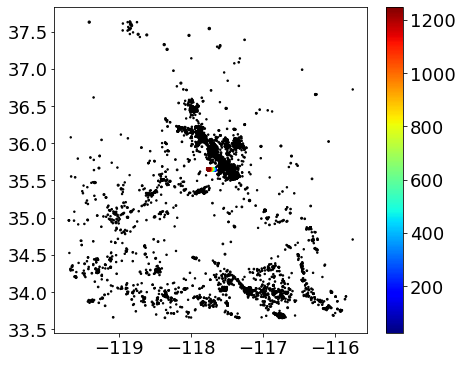

In [13]:
# TODO: add an inset with Zoom-in DAS channels
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(eq_lon, eq_lat, s=10**(eq_mag/5), c='k')
fig.colorbar(cmp)

### Calculate the arrival time from earthquake to each das channel using 1D velocity model. If the travel time table has already been calculated, load the prepared travel time table, calculate the interpolation function to estimate the arrival times.

In [15]:
# Work out a handy travel time table to do interpolation
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
tt_output_dir = '/kuafu/EventData/Ridgecrest/theoretical_arrival_time'
travel_time_table_file = tt_output_dir + '/travel_time_table.npz'

# from one event to all channels
event_arrival_P = np.zeros((DAS_channel_num, eq_num)) 
event_arrival_S = np.zeros((DAS_channel_num, eq_num)) 

# First look for the precalculated TTT, if not exists, get one from interpolating TauP 
if not os.path.exists(travel_time_table_file):
    model = TauPyModel(model='iasp91')

    # distance list
    distance_fit = np.linspace(0, 2, 100)
    # depth list
    depth_fit = np.arange(0, 100, 1)

    distance_grid, depth_grid = np.meshgrid(distance_fit, depth_fit)


    tavel_time_P_grid = np.zeros(distance_grid.shape)
    tavel_time_S_grid = np.zeros(distance_grid.shape)

    #for i_eq in tqdm.tqdm(range(10), desc="Calculating arrival time..."):
    for i_depth in tqdm.tqdm(range(depth_grid.shape[0]), desc="Calculating arrival time..."):   

        for i_distance in range(distance_grid.shape[1]):
            try:
                arrivals = model.get_ray_paths(depth_fit[i_depth], distance_fit[i_distance], phase_list=['p', 's'])
                tavel_time_P_grid[i_depth, i_distance] = arrivals[0].time
                tavel_time_S_grid[i_depth, i_distance] = arrivals[1].time 
            except:
                tavel_time_P_grid[i_depth, i_distance] = np.nan
                tavel_time_S_grid[i_depth, i_distance] = np.nan

    # save the calculated Travel time table
    np.savez(travel_time_table_file, distance_grid=distance_grid, depth_grid=depth_grid, 
             tavel_time_p_grid=tavel_time_P_grid, tavel_time_s_grid=tavel_time_S_grid)

    print('Travel time table calculated!')
    
    
# The TTT calculated or already exists, directly load it.
temp = np.load(travel_time_table_file)
distance_grid = temp['distance_grid']
depth_grid = temp['depth_grid']
tavel_time_p_grid = temp['tavel_time_p_grid']
tavel_time_s_grid = temp['tavel_time_s_grid']

# build the interpolation function
from scipy.interpolate import interp2d, griddata
#grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

ii = ~np.isnan(tavel_time_p_grid) # ignore the nan
# interp_f_p = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_p_grid[ii], kind='linear')
# interp_f_s = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_s_grid[ii], kind='linear')

for i_eq in tqdm.tqdm(range(eq_num), desc="Calculating arrival time..."):   
    # estimate the arrival time of each earthquake to all channels
    P_arrival = np.zeros(DAS_channel_num)
    S_arrival = np.zeros(DAS_channel_num)
    distance_to_source = locations2degrees(DAS_lat, DAS_lon, event_info_df.iloc[i_eq, :].latitude, event_info_df.iloc[i_eq, :].longitude)

    P_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_p_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))
    S_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_s_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))

    # 30s is the event time 
    P_arrival = 30 + P_arrival
    S_arrival = 30 + S_arrival

    DAS_info_df['P_arrival'] = P_arrival
    DAS_info_df['S_arrival'] = S_arrival

    DAS_info_df.to_csv(tt_output_dir + f'/1D_tt_{event_info_df.iloc[i_eq, :].event_id}.csv', index=False)

Calculating arrival time...:  11%|█         | 1354/12656 [06:21<53:02,  3.55it/s] 


KeyboardInterrupt: 

### Output the windowed data for ML phase/arrival time picking

In [16]:
# Save the segmented data for ML phase picking
# This is to save as HDF5
from scipy.interpolate import interp1d

data_folder = '/kuafu/EventData/Ridgecrest/data'
fig_folder = data_folder + '/figures'

for i_event in tqdm.tqdm(range(0, eq_num), desc="Extracting waveforms..."):
    if os.path.exists(os.path.join(data_folder, str(eq_id[i_event])+'.h5')):
        print(f'Event data {eq_id[i_event]} exists, skip...')
        continue

    try:
        das_path = '/kuafu/zshen/Ridgecrest_data/1hoursegy/total/'
        file_name = eq_das_files[i_event]

        data0 = read_PASSCAL_segy(das_path + file_name, 1250, 900000, 0)
        data0 = data0[DAS_index, :]
    except:
        continue

    das_dt = 3600 / data0.shape[1]
    data_diff = np.diff(data0, axis=1)/das_dt / 1e3 * Ridgecrest_conversion_factor # convert from nano strain rate to micro strain rate

    # time information 
    das_time = np.linspace(das_dt/2,3600-das_dt/2,data_diff.shape[1])

    # Taper the data
    t_begin = eq_time_UTCDateTime[i_event] - eq_das_t0[i_event] - 30
    t_end = eq_time_UTCDateTime[i_event] - eq_das_t0[i_event] + 90

    # segmented data
    ii_time = (das_time >= t_begin) & (das_time <= t_end)
    data_diff = data_diff[:, ii_time]
    das_time = das_time[ii_time]   
    
    # Downsample from 250 Hz to 100 Hz using interp
    das_dt_ds = 0.01
    das_time_ds = np.linspace(t_begin, t_end - das_dt_ds, 12000)

    downsample_f = interp1d(das_time, data_diff, axis=1, bounds_error=False, fill_value=0)
    data_diff_ds = downsample_f(das_time_ds)

    event_data = data_diff_ds.T
    event_info = {}
    event_info['event_id'] = eq_id[i_event]
    event_info['event_time'] = eq_time_UTCDateTime[i_event].isoformat()
    event_info['begin_time'] = (eq_time_UTCDateTime[i_event] - 30).isoformat() + '+00:00'
    event_info['end_time'] = (eq_time_UTCDateTime[i_event] + 90).isoformat() + '+00:00'
    event_info['latitude'] = eq_lat[i_event]
    event_info['longitude'] = eq_lon[i_event] 
    event_info['depth_km'] = eq_dep[i_event]
    event_info['magnitude'] = eq_mag[i_event]
    event_info['magnitude_type'] = 'ml'
    event_info['source'] = 'scsn'
    event_info['dt_s'] = das_dt_ds
    event_info['dx_m'] = 8
    event_info['das_array'] = 'Ridgecrest'

    save_rawevent_h5(os.path.join(data_folder, str(eq_id[i_event])+'.h5'), event_data, event_info)


    # Show data
    fig, ax1 = plt.subplots(figsize=(8,4))
    pclip=99.5
    clipVal = np.percentile(np.absolute(data_diff), pclip)
    # Vx
    ax1.imshow(event_data, 
                extent=[0, event_data.shape[1], das_time[-1], das_time[0]],
                aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

    # ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_P[:, i_event], '--g', zorder=10)
    # ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_S[:, i_event], '-g', zorder=10)

    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()

    plt.savefig(fig_folder + f'/{eq_id[i_event]}.png', bbox_inches='tight')
    plt.close('all')

Extracting waveforms...:   0%|          | 30/12656 [00:24<3:52:10,  1.10s/it]

Event data 38521895 exists, skip...


Extracting waveforms...:   0%|          | 32/12656 [00:41<6:50:18,  1.95s/it]

Event data 38521919 exists, skip...


Extracting waveforms...:   0%|          | 38/12656 [02:16<35:00:33,  9.99s/it]

Event data 38522055 exists, skip...
Event data 37248948 exists, skip...


Extracting waveforms...:   0%|          | 41/12656 [02:33<28:46:52,  8.21s/it]

Event data 38522071 exists, skip...


Extracting waveforms...:   0%|          | 43/12656 [02:52<29:36:57,  8.45s/it]

Event data 38522103 exists, skip...


Extracting waveforms...:   0%|          | 48/12656 [03:51<41:53:19, 11.96s/it]

Event data 38522175 exists, skip...
Event data 37486749 exists, skip...


Extracting waveforms...:   0%|          | 51/12656 [04:09<22:41:03,  6.48s/it]

In [13]:
# Test loading data
data_folder = '/kuafu/EventData/Ridgecrest/data'
data1, info1 = load_rawevent_h5(data_folder + '/39634983.h5')

In [94]:
# correct all the stored data with the factor Ridgecrest_conversion_factor
# data_folder = '/kuafu/EventData/Ridgecrest/data'
# files = glob.glob(data_folder + '/*.h5')
# eq_num = len(files)

# for i_event in tqdm.tqdm(range(eq_num), desc="Extracting waveforms..."):

#     with h5py.File(files[i_event], 'r+') as fid:
#         data = fid['data'][:]
#         fid['data'][:] = data*Ridgecrest_conversion_factor


#     # data_diff = data_diff * Ridgecrest_conversion_factor
#     # # Store back to hd5 file
#     # TBD
    

Extracting waveforms...: 100%|██████████| 4037/4037 [1:23:15<00:00,  1.24s/it]


### Wait for ML results from Weiqiang. TODO: trying to include his code here to directly refind the time picking.

### Load the ML-picked arrival time, and check how the ML picking works

In [ ]:
from scipy.interpolate import interp1d

def extrapolate_arrival_time(ml_picks, kind='linear'):
    channel = np.array(ml_picks['station_name'])
    phase_index = np.array(ml_picks['phase_index'])
    channel_all = np.arange(0, DAS_channel_num)
    if kind is None:
        phase_index_extrap = np.ones(channel_all.shape) * -1
        phase_index_extrap[channel] = phase_index
        
    else:
        interp_f = interp1d(channel, phase_index, kind=kind, fill_value='extrapolate')
        phase_index_extrap = interp_f(channel_all).astype('int')
    
    return phase_index_extrap

In [ ]:
extrapolate_ml_picking = False

# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for eq_id_current in eq_id:
      
    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
            fig_name = f'{eq_id_current}_ml_extrap_nearest.png'
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            fig_name = f'{eq_id_current}_ml.png'
        
    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]
        
        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        # Slight modify only for plotting purpose
        event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
        event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

        # Show data
        fig, ax1 = plt.subplots(figsize=(16,8))
        pclip=99.5
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        # Vx
        ax1.imshow(data_diff, 
                    extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        ax1.plot(event_arrival_P_ml, '--k', linewidth=2, zorder=10)
        ax1.plot(event_arrival_S_ml, '-k', linewidth=2, zorder=10)
        
        ax1.set_title(f'Event ID: {eq_id_current}')
        ax1.set_xlabel("Channel number")
        ax1.set_ylabel("Time [s]")
        ax1.grid()

        plt.savefig(das_path + '/' + fig_name)
        plt.close('all')
        print(f'Event {eq_id_current} done!')
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

### Now use the ML pick time to extract maximum amplitude

In [ ]:
# apply mask onto the data
def extract_maximum_amplitude(time_list, data_matrix, t1, t2):
    t1 = t1[:, np.newaxis]
    t2 = t2[:, np.newaxis]
    time_list = time_list[np.newaxis, :]
    
    # broadcast comparison
    mask_index = (time_list >= t1) & (time_list < t2)
    data_matrix_mask = data_matrix.copy()
    # first extract the time of maximum P
    data_matrix_mask[~mask_index] = -1e20
    max_index = np.nanargmax(data_matrix_mask, axis=1)
    max_time = time_list[:, max_index]
    max_time[:, max_index==0] = np.nan
    max_time[:, max_index==(time_list.shape[1]-1)] = np.nan
    max_time_ref1 = max_time.flatten() - t1.flatten()
    max_time_ref2 = t2.flatten() - max_time.flatten() 
    # then extract the maximum P 
    data_matrix_mask[~mask_index] = np.nan
    max_amplitude = np.nanmax(data_matrix_mask, axis=1)
    
    return max_amplitude, max_time_ref1, max_time_ref2

# # calculate the SNR given the P arrival time
# def calculate_SNR(time_list, data_matrix, t1, twin_noise, twin_signal):
#     t1 = t1[:, np.newaxis]
#     time_list = time_list[np.newaxis, :]

#     noise_index = (time_list < t1) & (time_list >= t1 - twin_noise) # noise index
#     signal_index = (time_list >= t1) & (time_list <= t1 + twin_signal) # signal index

#     noise_matrix = data_matrix.copy()
#     signal_matrix = data_matrix.copy()
#     noise_matrix[~noise_index] = np.nan
#     signal_matrix[~signal_index] = np.nan

#     noise_power = np.nanmean(noise_matrix ** 2, axis=1)
#     signal_power = np.nanmean(signal_matrix ** 2, axis=1)

#     snr = 10 * np.log10(signal_power / noise_power)
#     return snr

# calculate the SNR given the P arrival time
def calculate_SNR(time_list, data_matrix, twin_noise, twin_signal):
    '''calculate the SNR given the noise and signal time window list [begin, end] for each channel'''
    time_list = time_list[np.newaxis, :]

    noise_index = (time_list < twin_noise[1]) & (time_list >= twin_noise[0]) # noise index
    signal_index = (time_list <= twin_signal[1]) & (time_list >= twin_signal[0]) # signal index

    noise_matrix = data_matrix.copy()
    signal_matrix = data_matrix.copy()
    noise_matrix[~noise_index] = np.nan
    signal_matrix[~signal_index] = np.nan

    noise_power = np.nanmean(noise_matrix ** 2, axis=1)
    signal_power = np.nanmean(signal_matrix ** 2, axis=1)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr


from scipy.signal import butter, filtfilt

def convert_to_strain(strain_rate, das_time, filt=True, filt_freq=0.5):
    dt = das_time[1] - das_time[0]
    strain_temp = np.cumsum(strain_rate * das_time, axis=1)
    if filt:
        aa, bb = butter(2, filt_freq * 2 * dt, btype='high')
        strain_temp = filtfilt(aa, bb, strain_temp, axis=1)
        
    return strain_temp


In [ ]:
extrapolate_ml_picking = False

from obspy.geodetics import locations2degrees
import glob

# extract the maximum amplitude
peak_ampliutde_P_all = [] # strain rate
peak_ampliutde_S_all = [] # strain rate
peak_strain_P_all = [] # strain
peak_strain_S_all = [] # strain
snrP_all = [] # SNR from P strain rate (P, P + 10)
snrS_all = [] # SNR from S strain rate (S, S + 20) 
max_P_time_all1 = [] # time of P maximum relative to P
max_P_time_all2 = [] # time of P maximum relative to S
max_S_time_all = [] # time of S maximum relative to S

distance_all = []
magnitude_all = []
event_id_all = []
channel_id_all = []

# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for i_event, eq_id_current in enumerate(eq_id):
      
    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        # extrapolate the index in case the ML picking is imcomplete
        event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p)
        event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s)
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')

        else:
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)

    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]

        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        end_time = np.ones(event_arrival_S_ml.shape) * das_time[-1]

        data_diff = data_diff.T
        # Extract the maximum given the P and S arrival time
        max_P_amplitude, max_P_time1, max_P_time2 = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_amplitude, max_S_time, _ = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_S_ml, end_time)

        # prepare the time window list for SNR calculation
        event_arrival_P_ml_temp = event_arrival_P_ml[:, np.newaxis]
        event_arrival_S_ml_temp = event_arrival_S_ml[:, np.newaxis]
        twin_noise = [event_arrival_P_ml_temp-10, event_arrival_P_ml_temp]
        twin_signal_P = [event_arrival_P_ml_temp, event_arrival_P_ml_temp + 10]
        twin_signal_S = [event_arrival_S_ml_temp, event_arrival_S_ml_temp + 20]

        snrP = calculate_SNR(das_time, data_diff, twin_noise, twin_signal_P)
        snrS = calculate_SNR(das_time, data_diff, twin_noise, twin_signal_S)
        
        # Also extract strain maximum
        strain = convert_to_strain(data_diff, das_time)
        # Extract the maximum strain given the P and S arrival time
        max_P_strain, _, _ = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_strain, _, _ = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_S_ml, end_time)
        
        
        

        # Distance from each channel to the source
        distance_to_source = locations2degrees(DAS_lat, DAS_lon, eq_lat[i_event], eq_lon[i_event])

        # Magnitude of each earhtquake
        magnitude_all.append(np.ones(DAS_lat.shape) * eq_mag[i_event])
        # A simple event label
        event_id_all.append((np.ones(DAS_lat.shape) * eq_id_current).astype('int'))
        # Channel id
        channel_id_all.append(DAS_index)


        peak_ampliutde_P_all.append(max_P_amplitude)
        peak_ampliutde_S_all.append(max_S_amplitude)
        peak_strain_P_all.append(max_P_strain)
        peak_strain_S_all.append(max_S_strain)
        max_P_time_all1.append(max_P_time1)
        max_P_time_all2.append(max_P_time2)
        max_S_time_all.append(max_S_time)
        distance_all.append(distance_to_source)
        snrP_all.append(snrP)
        snrS_all.append(snrS)
        print('=' * 10 + f'Event {eq_id_current} done!' + '=' * 10)
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

### Flatten all the measured results. Output all the results.

In [ ]:
peak_ampliutde_P_all_flatten = np.array(peak_ampliutde_P_all).flatten()
peak_ampliutde_S_all_flatten = np.array(peak_ampliutde_S_all).flatten()
peak_strain_P_all_flatten = np.array(peak_strain_P_all).flatten()
peak_strain_S_all_flatten = np.array(peak_strain_S_all).flatten()
snrP_all_flatten = np.array(snrP_all).flatten()
snrS_all_flatten = np.array(snrS_all).flatten()
max_P_time_all1_flatten = np.array(max_P_time_all1).flatten()
max_S_time_all_flatten = np.array(max_S_time_all).flatten()
max_P_time_all2_flatten = np.array(max_P_time_all2).flatten()

distance_all_flatten = np.array(distance_all).flatten()
distance_all_km_flatten = distance_all_flatten * 113
magnitude_all_flatten = np.array(magnitude_all).flatten()
event_id_all_flatten = np.array(event_id_all).flatten()
channel_id_all_flatten = np.array(channel_id_all).flatten()

In [ ]:
# Combine all the results together for a DataFrame
all_combined = np.array([event_id_all_flatten, 
                         magnitude_all_flatten, 
                         distance_all_km_flatten, 
                         peak_ampliutde_P_all_flatten, 
                         peak_ampliutde_S_all_flatten,
                         peak_strain_P_all_flatten,
                         peak_strain_S_all_flatten,
                         channel_id_all_flatten,
                         snrP_all_flatten,
                         snrS_all_flatten,
                         max_P_time_all1_flatten,
                         max_P_time_all2_flatten,
                         max_S_time_all_flatten]).T

peak_amplitude_df = pd.DataFrame(data=all_combined, 
                                 columns=['event_id', 'magnitude', 'distance_in_km', 'peak_P', 'peak_S','peak_P_strain', 'peak_S_strain', 'channel_id', 'snrP', 'snrS', 'max_P_time','max_P_time2','max_S_time'])


peak_amplitude_df = peak_amplitude_df.dropna()

In [ ]:
# An additional step to remove some outliers (> 10 std for each earthquake)
for event_id in eq_id:
    peak_amplitude_df_eq = peak_amplitude_df[peak_amplitude_df.event_id == event_id]
    peak_amplitude_df.drop(peak_amplitude_df_eq[abs(peak_amplitude_df_eq.peak_P) > 10 * peak_amplitude_df_eq.peak_P.std()].index, inplace=True)

In [9]:
# Write the results to a csv file
results_output_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/peak_amplitude_scaling_results_strain_rate'
if not os.path.exists(results_output_dir):
    os.mkdir(results_output_dir)


output_file_name = results_output_dir + '/peak_amplitude_M3+.csv'

peak_amplitude_df.to_csv(output_file_name, index=False)

In [12]:
# Load the peak amplitude results
import pandas as pd
import numpy as np

results_output_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/peak_amplitude_scaling_results_strain_rate'

peak_amplitude_file_name = results_output_dir + '/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(peak_amplitude_file_name)

In [13]:
peak_amplitude_df

,event_id,magnitude,distance_in_km,peak_P,peak_S,peak_P_strain,peak_S_strain,channel_id,snrP,snrS,max_P_time,max_P_time2,max_S_time
0,38522647.0,4.17,15.325319,23579.884399,73097.312063,433493.193261,6.871808e+06,404.0,35.693535,36.059296,2.30,0.44,8.46
1,38522647.0,4.17,15.333454,17655.834243,74298.456347,271468.406368,6.887392e+06,405.0,37.439789,38.091179,1.66,1.12,8.42
2,38522647.0,4.17,15.341499,15318.217588,71285.810885,292488.929466,7.255463e+06,406.0,38.677017,39.232899,1.72,1.04,8.46
3,38522647.0,4.17,15.349532,25213.499797,58182.489011,509589.239435,6.207566e+06,407.0,33.928749,34.044182,2.44,0.22,8.78
4,38522647.0,4.17,15.357668,22299.974523,63343.039353,555415.930803,6.249438e+06,408.0,25.131323,24.872915,2.62,0.04,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164837,39659271.0,3.59,54.036639,2401.561117,3173.432513,39373.708912,1.740473e+05,1239.0,5.012650,3.286391,0.36,6.44,0.50
164838,39659271.0,3.59,54.042592,1798.278541,2803.198696,38138.753290,1.891986e+05,1240.0,4.204865,2.843199,0.34,6.46,0.48
164839,39659271.0,3.59,54.048613,2023.063359,2657.749696,35935.775302,1.569868e+05,1241.0,3.043295,1.893932,1.14,5.66,0.50
164840,39659271.0,3.59,54.054567,2697.417605,2380.074333,35324.321443,1.451772e+05,1242.0,1.710825,-0.085950,0.38,6.50,17.08


In [ ]:
plt.plot(peak_amplitude_df.magnitude, peak_amplitude_df.max_P_time, 'x', alpha=0.01)

In [ ]:
plt.plot(peak_amplitude_df.distance_in_km, peak_amplitude_df.max_P_time, 'x', alpha=0.01)

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(14,12))
sns.set_theme(style="white")
sns.color_palette("Set2")
corr = peak_amplitude_df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="seismic", fmt='.1g', vmax=1, vmin=-1)
plt.savefig(results_output_dir + '/ridgecrest_data_corr.png')

In [ ]:
peak_amplitude_df_temp = peak_amplitude_df.iloc[::5, :]
peak_amplitude_df_temp['log10(distance)'] = np.log10(peak_amplitude_df_temp.distance_in_km)
peak_amplitude_df_temp['log10(peak_P)'] = np.log10(peak_amplitude_df_temp.peak_P)
peak_amplitude_df_temp['P/S'] = peak_amplitude_df_temp.peak_P/peak_amplitude_df_temp.peak_S
plt.figure(figsize=(14,8))
sns.pairplot(peak_amplitude_df_temp[['magnitude','log10(distance)', 'max_P_time','max_P_time2', 'log10(peak_P)','P/S']], kind='hist', diag_kind="kde", corner=True)
#plt.savefig(results_output_dir + '/ridgecrest_data_statistics.png')

In [ ]:
peak_amplitude_df_temp = peak_amplitude_df.iloc[::5, :]
peak_amplitude_df_temp['log10(distance)'] = np.log10(peak_amplitude_df_temp.distance_in_km)
peak_amplitude_df_temp['log10(peak_P)'] = np.log10(peak_amplitude_df_temp.peak_P)
peak_amplitude_df_temp['P/S'] = peak_amplitude_df_temp.peak_P/peak_amplitude_df_temp.peak_S
plt.figure(figsize=(14,8))
sns.pairplot(peak_amplitude_df_temp[['magnitude','log10(distance)', 'log10(peak_P)']], kind='hist', diag_kind="kde", corner=True)
plt.savefig(results_output_dir + '/ridgecrest_data_statistics_simplified.png')

In [ ]:
peak_amplitude_df

In [ ]:
# Load the peak amplitude results of Mammoth data
import pandas as pd
import numpy as np

results_output_dir = '/kuafu/yinjx/multi_array_combined_scaling/combined_strain_scaling_MM'

peak_amplitude_file_name = results_output_dir + '/peak_amplitude_region_site_10.csv'
peak_amplitude_df = pd.read_csv(peak_amplitude_file_name)

In [ ]:
peak_amplitude_df

In [ ]:
peak_amplitude_df_temp = peak_amplitude_df.iloc[::5, :]
peak_amplitude_df_temp['log10(distance)'] = np.log10(peak_amplitude_df_temp.distance_in_km)
peak_amplitude_df_temp['log10(peak_P)'] = np.log10(peak_amplitude_df_temp.peak_P)
peak_amplitude_df_temp['P/S'] = peak_amplitude_df_temp.peak_P/peak_amplitude_df_temp.peak_S
plt.figure(figsize=(14,8))
sns.pairplot(peak_amplitude_df_temp[['magnitude','log10(distance)', 'log10(peak_P)','P/S']], kind='hist', diag_kind="kde", corner=True)
plt.savefig(results_output_dir + '/mammoth_data_statistics.png')

In [ ]:
# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for eq_id_current in [38544311]:

    # look for the corresponding ML picks
    ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
    ml_picks = pd.read_csv(ml_picks_file[0])

    # extract the picked information
    ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
    ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

#     # remove some duplicated picks, only keep those with higher probability
#     ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
#     ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')

#     # extrapolate the index in case the ML picking is imcomplete
#     event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p)
#     event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s)

In [ ]:
ml_picks_p

In [ ]:
ml_picks_s

In [ ]:
ml_picks

In [ ]:
ml_picks_p['station_name']

In [ ]:
ml_picks_s[ml_picks_s.duplicated(subset=['station_name'], keep=False)]

In [ ]:
a = np.ones(3)